In [79]:
import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as Image
import cv2
import tensorflow as tf
import time
from skimage.measure import block_reduce
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


# Data import & Pre-processing --------------------------------------------------------------------

In [2]:
# Gets paths for images 
def get_catalog(file):
    species = []
    pics = []
    for root, subdir, files in os.walk(file):
        species.append(subdir)
        pics.append(files)
    species = species[0]
    
    catalog = {}
    for i in range(len(species)):
        catalog[species[i]] = pics[i+1]
    return catalog

In [3]:
#Gets dictionary of pictures in grayscalse from paths
def get_pics_gray(catalog,path, species_index,pic_index):
    count = 1
    new_catalog = {}
    for specie in catalog:
        images =[]
        for i in range(pic_index):
            image = cv2.imread(path + specie + '/' + catalog[specie][i],cv2.IMREAD_GRAYSCALE)
            res = cv2.resize(image, dsize=(98, 64), interpolation=cv2.INTER_NEAREST)
            images.append(res.flatten())
        new_catalog[specie] = np.array(images)
        if count == species_index:
            break
        count += 1
        
    return new_catalog
    

In [4]:
# gets dictionary of pictures in rgb from paths
def get_pics(catalog,path, species_index,pic_index):
    count = 1
    new_catalog = {}
    for specie in catalog:
        images =[]
        for i in range(pic_index):
            image = cv2.imread(path + specie + '/' + catalog[specie][i])
            res = np.array(cv2.resize(image, dsize=(112, 112), interpolation=cv2.INTER_NEAREST))
            images.append(np.reshape(res,(12544,3)))
        new_catalog[specie] = images
        if count == species_index:
            break
        count += 1
        
    return new_catalog

In [5]:
# Plots sample pictures
def plot_sample(catalog, n_species,n_pics,flag):
    count = 1
    for specie in catalog:
        for i in range(n_pics):
            if flag:
                picture = plt.imshow(np.reshape(catalog[specie][i],(64,98)))
            else:
                picture = plt.imshow(np.reshape(catalog[specie][i],(112,112,3)))
            plt.show()
        if count == n_species:
            break
        count += 1
        

In [6]:
# Returns dictionary: species as keys, mxn array with pictures as rows and pixels as columns. 
def import_pics(path, nspec,npic):
    bird_catalog = get_catalog(path)
    pics = get_pics_gray(bird_catalog,path, nspec, npic)
    return pics

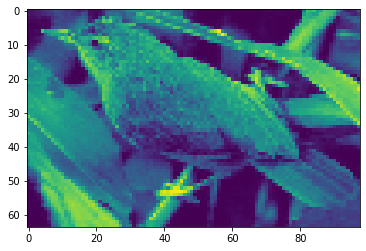

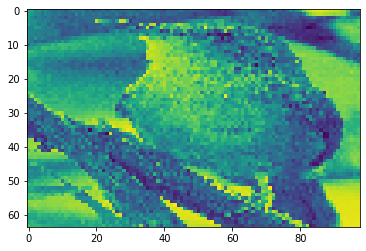

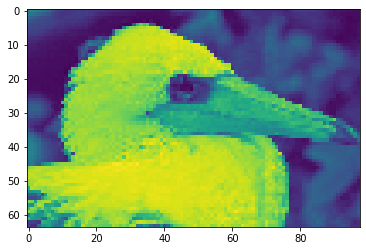

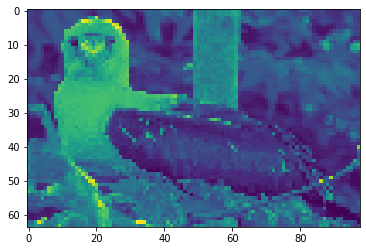

In [10]:
# Main function for data preprocessing ----------------------------------------------------------------------------------
seed = 2
np.random.RandomState(seed)


#Declare variables 
train_file, valid_file, test_file = 'data/birds/train/', 'data/birds/valid/', 'data/birds/test/'
num_species_train, num_pics_train = 2, 10
num_species_val, num_pics_val = 2, 5
num_species_test, num_pics_test = 2, 5

#get pictures
train_pictures = import_pics(train_file, num_species_train, num_pics_train)
valid_pictures = import_pics(valid_file, num_species_val, num_pics_val)
test_pictures = import_pics(test_file, num_species_test, num_pics_test)

#plot samples of imported images
plot_sample(test_pictures,2,2,1)


# Dimensionality Reduction -------------------------------------------------------------------------

In [89]:
def eigendecomposition(images):
    species_values = {}
    shape = []
    for specie, values in images.items():
        mean = np.mean(values,axis=0)
        x = (values - mean) / 255
        
        U, S, V = np.linalg.svd(x.T)
        shape = U.shape
        species_values[specie] = [U, S, V, mean]
    return species_values, shape

In [90]:
def get_eigenspecies(eigen,n_comp):
    species_eigenvectors = {}
    for spec, vals in  eigen.items():
        U = vals[0]
        mean = vals[3]
        eigenvectors =  U[:,:n_comp]
        #for i in range(eigenvectors.shape[1]):
            #plt.imshow(np.reshape(eigenvectors[:,i],(64,98)), cmap='gray')
            #plt.title('eigenspecies'+str(i+1))
            #plt.savefig('eigenfaces/subject'+flag+str(n+1)+'.jpg')
            #plt.show()
        species_eigenvectors[spec] = (eigenvectors, mean)
    return species_eigenvectors

In [91]:
def get_residuals(eigenspecies,test):
    test_images = []
    for spec,test_im in test.items():
        if len(test_images) == 0:
            test_images = test_im
        else:
            test_images = np.concatenate((test_images,test_im),axis=0)
    
    residuals_matrix = []
    for image in test_images:
        per_species_residual = []
        for specie, metrics in eigenspecies.items():
            pre_image = np.reshape((image - metrics[1]) / 255,(6272,1))
            residual = np.linalg.norm((pre_image - (metrics[0] @ metrics[0].T @ pre_image)))**2
            per_species_residual.append(residual)
        residuals_matrix.append(per_species_residual)
    return np.array(residuals_matrix)
    

In [92]:
def get_classes(n_test_species,n_test_pics):
    temp_a = np.arange(n_test_species)
    temp_b = np.repeat(temp_a,n_test_pics)
    return np.array(temp_b +1)
    
    

In [105]:
def eval_model(eigenspec,test_im,shape, n_test_species, n_test_pics):
    score = []
    principal_comp = []
    counter = np.arange(1,shape[0], 100)
    for i in counter:
        eigenspecies = get_eigenspecies(eigenspec, i)
        residuals = get_residuals(eigenspecies,test_im)
        classification = residuals.argmin(axis=1) + 1
        true_classes = get_classes(n_test_species,n_test_pics)
        score.append(accuracy_score(true_classes,classification))
        principal_comp.append(i)
        print(i," iteration complete.")
    return score, principal_comp
    

In [94]:
start = time.time()
specie_eigenvalues, shape = eigendecomposition(train_pictures)

In [ ]:
accuracy, parameter = eval_model(specie_eigenvalues,test_pictures,shape,2,5)
#end = time.time()
#total_time = end-start
#print("The algorithm took " + total_time + "seconds.")


1  iteration complete.
101  iteration complete.
201  iteration complete.
301  iteration complete.
401  iteration complete.
501  iteration complete.
601  iteration complete.
701  iteration complete.
801  iteration complete.
901  iteration complete.
1001  iteration complete.
1101  iteration complete.
1201  iteration complete.
1301  iteration complete.
1401  iteration complete.
1501  iteration complete.
1601  iteration complete.
1701  iteration complete.
1801  iteration complete.
1901  iteration complete.
2001  iteration complete.
2101  iteration complete.
2201  iteration complete.
2301  iteration complete.
2401  iteration complete.
2501  iteration complete.
2601  iteration complete.
2701  iteration complete.
2801  iteration complete.
2901  iteration complete.
3001  iteration complete.
3101  iteration complete.
3201  iteration complete.
3301  iteration complete.
3401  iteration complete.
3501  iteration complete.
3601  iteration complete.
3701  iteration complete.
3801  iteration complete

In [100]:
print(accuracy)

NameError: name 'accuracy' is not defined

# Density Estimation -----------------------------------------------------------------------------------

# Traditional Classification --------------------------------------------------------------------------

# Deep Learning -----------------------------------------------------------------------------------------

In [ ]:
for specie in pictures:
    for n in pictures[specie]:
        print(n.shape)